In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg

In [2]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    h = 1/(sqrtinputsize-1)
    KX = np.zeros([inputsize,inputsize+1])
    KY = np.zeros([inputsize+1,inputsize])
    for i in range(sqrtinputsize):
        for j in range(sqrtinputsize+1):
            KX[i][j] = a(j*h-0.5*h,i*h)
    for i in range(sqrtinputsize+1):
        for j in range(sqrtinputsize):
            KY[i][j] = a(j*h,i*h-0.5*h)
    OUTPUT = (gallery.nonlinearPoisson((sqrtinputsize,sqrtinputsize),KX,KY)).to_full()
    return OUTPUT

In [3]:
def Multigrid_circle(inputsize, A_A, B, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = 4*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

In [4]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def rhoAuto(INPUT):
    R = INPUT[0]
    w = INPUT[1]
    P = 4*np.transpose(R)
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

In [5]:
def optimizer_GD(inputsize, A, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,4*np.transpose(R),R,w,s)
    INPUT = [R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    R -= learning_rate*delta[0]
    w -= learning_rate*delta[1]
    rhonew = rho(inputsize,A,4*np.transpose(R),R,w,s)
    return R, w, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            P = 4*np.transpose(R)
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhonew <= rhoold and i<100:
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        Radius.append(Rnew)
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

In [6]:
finegridsize = 5
s = 1
w = 2/3
MAX_ITER = 50

In [7]:
e = 0.01
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

In [8]:
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize-1)
A0 = Poisson(inputsize)
A1 = NonlinearPoisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 4*np.transpose(R)

In [9]:
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A = gallery.nonlinearPoisson((n,n), kx, ky)

In [10]:
PR_stencil_type = "m9p"
gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
num_iter = 2500
step_size = 1e-4
opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/2500
Upper bound estimation = 0.25765253890385337
Iteration 200/2500
Upper bound estimation = 0.24403277810167542
Iteration 300/2500
Upper bound estimation = 0.23471522723605748
Iteration 400/2500
Upper bound estimation = 0.22482163037804406
Iteration 500/2500
Upper bound estimation = 0.21385890403845095
Iteration 600/2500
Upper bound estimation = 0.2001639485547799
Iteration 700/2500
Upper bound estimation = 0.19278222408317525
Iteration 800/2500
Upper bound estimation = 0.1836148811923769
Iteration 900/2500
Upper bound estimation = 0.17730325694858987
Iteration 1000/2500
Upper bound estimation = 0.17143415735179499
Iteration 1100/2500
Upper bound estimation = 0.1669151048849301
Iteration 1200/2500
Upper bound estimation = 0.162825564232739
Iteration 1300/2500
Upper bound estimation = 0.1606125977114929
Iteration 1400/2500
Upper bound estimation = 0.15803634070645842
Iteration 1500/2500
Upper bound estimation = 0.1570821315407261
Iteration 1600/2500
Upper bound estimatio

In [11]:
print(gmm)
convergence = gmm.get_optimizer_convergence()
conv_time = gmm.get_optimization_time()
gmm.update_prd(opt_par)
DMM_rho = gmm.compute_rho()
print("DMM rho = {}".format(DMM_rho))

Dimension of matrix A for levels:
Level = 0, dimension = (15, 15)
Level = 1, dimension = (31, 31)

DMM rho = 0.13278393553302176


[1.19379696e+01 1.83724278e+00 1.99128057e-01 2.10789539e-02
 1.81000437e-03 2.15632043e-04 2.01701855e-05 2.41188836e-06
 2.71170269e-07 3.29724516e-08 4.00288594e-09 4.94044688e-10
 6.13382554e-11 7.67644517e-12 9.64307926e-13 1.23515673e-13
 1.92857738e-14 1.06274281e-14 1.15950760e-14 9.99271024e-15
 1.14747113e-14 1.09438256e-14 1.21866075e-14 1.09982622e-14
 1.06314661e-14 1.09126106e-14 1.09154499e-14 1.14375157e-14
 1.04210740e-14 1.10779280e-14 1.04128104e-14 1.03605857e-14
 1.11662264e-14 1.15273842e-14 1.10514041e-14 1.05358869e-14
 1.11183983e-14 1.07518604e-14 1.01993195e-14 1.15503424e-14
 9.39243823e-15 1.07378668e-14 1.05727855e-14 1.14353073e-14
 1.17949035e-14 1.16593450e-14 1.13474105e-14 1.07888840e-14
 1.15599604e-14 1.22536050e-14]


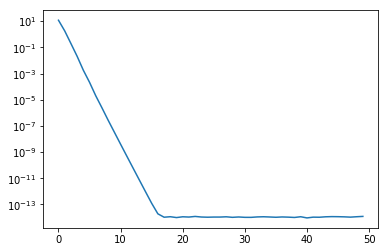

In [12]:
x = gmm.solve(RightF, np.random.randn(A.shape), tol=0, max_iter=50)
print(gmm.get_gmg_convergence())
plt.semilogy(gmm.get_gmg_convergence())

In [13]:
np.linalg.norm(Ureal - x,np.inf)

0.4460645328396121

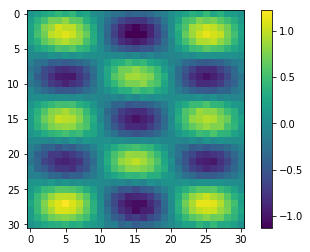

In [14]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

In [15]:
np.set_printoptions(threshold=np.inf)
print("omega = {}".format(opt_par[2]))

omega = 0.8003095750203217


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)


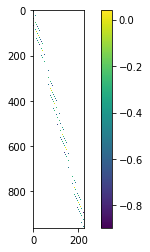

In [16]:
P = opt_par[0][0]
k = int(2**(np.log2(n+1)-1)-1) 
P_Matrix = np.zeros([n**2,k**2])
for i in range(k):
    for j in range(k):
        C = P[i][j]
        for l in range(3):
            for m in range(3):
                P_Matrix[n*(2*i+l)+(2*j+m)][k*i+j] = C[l][m]
plt.imshow(np.log10(np.abs(P_Matrix)))
plt.colorbar()

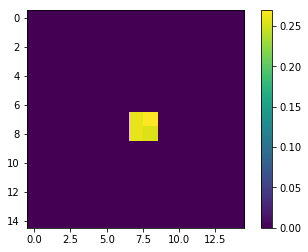

In [17]:
basis1 = P_Matrix[512][:]
basis1 = basis1.reshape([sqrtoutputsize,sqrtoutputsize])
plt.imshow(basis1)
plt.colorbar()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


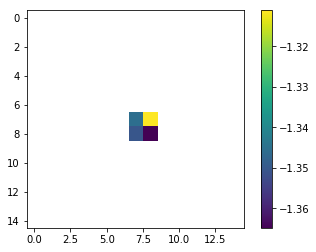

In [18]:
basis1 = P_Matrix[512][:]
basis1 = basis1.reshape([sqrtoutputsize,sqrtoutputsize])
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()